## GMM: Beyond k-Means

**Unsupervised learning: clustering, data generation**

**Abstract:** When thinking of unsupervised learning models, k-means clustering is probably the first example to come to mind. And for good reason. It is simple to explain to your grandma (or top management if you will) and it gets the job done in most cases. However, it has clear limitations. A good alternative is Gaussian mixture models (GMM), its "brother from another mother". This notebook aims to building the intuition for the limitations of k-means and why GMM is a suitable alternative in such cases.

In addition, this notebook provides a visual example of how GMM can be used to produce new data from the probability distribution it estimates. This is meant as a somewhat fun excursus.

**Topics covered:** k-means clustering, Gaussian mixture models (GMM), Akaike Information Criterion (AIC), data generation.

**What is k-means and what's wrong with it?** In a nutshell, k-means is a nonparametric, nonprobabilistic clustering model based on an expectation-maximization (EM) algorithm that, in its convergence, assigns each data point to its closest cluster center. It follows the following steps:

<p>&nbsp; &nbsp; 1. Guess some initial cluster centers</p>
<p>&nbsp; &nbsp; 2. Repeat until converged (i.e. until there is no more tangible improvement in the fitness function)</p>
<p>&nbsp; &nbsp; &nbsp; a) E-step: assign points to nearest center, i.e. update expectation to what cluster each point belongs to</p>
<p>&nbsp; &nbsp; &nbsp; b) M-step: set cluster centers to the mean, i.e. maximizing fitness function defining cluster centers</p>

Being nonparametric appeals to many as there is little to none hyperparameter setting and tuning. The only parameter that needs to be defined from the get-go is the number of cluster centers. The fact that it is nonprobabilistic though, means that there is no uncertainty (i.e. probability) attached to assigning points to nearby centers. This is especially an issue when clusters overlap. This is the first issue. The second issue stems from the simple distance-from-cluster-center point allocation k-means performs. This approach runs under the implicit assumption that the clusters are circular. One can think of scenarios where such an assumtion doesn't hold. The standard k-means algorithm doesn't provide a way to account for other shapes such as ellipses and the likes.

In order to visualize these two shortcomings in the k-means algorithm we generate two artificial datasets below. We will then show how we can circumvent this issues using GMM instead. 

**Setup.**

In [1]:
from sklearn.datasets._samples_generator import make_blobs
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
# Generate random data
X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=.9, random_state=9)

In [3]:
def plot_kmeans(kmeans, X, title=None):
    '''Given a trained k-means algorithm, plot the clusters and
    respective implied circular shapes.'''
    # Fit model
    y_pred = kmeans.fit_predict(X)
    # Plot clusters
    ax = plt.gca()
    ax.set_title(title)
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=y_pred, s=80, edgecolors='w')
    # Plot implied circular models
    centers = kmeans.cluster_centers_
    radii = [cdist(X[y_pred == i], [c]).max() for i, c in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, color='k', 
                                fc='gray', ls='-', lw=2, alpha=.1, zorder=1))

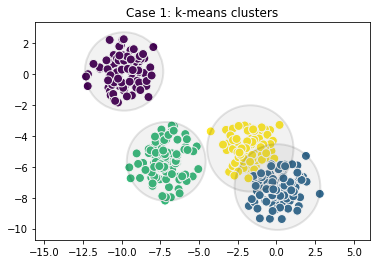

In [4]:
kmeans = KMeans(4, random_state=0).fit(X)
plot_kmeans(kmeans, X, title='Case 1: k-means clusters')

The purple and green clusters are relatively easy to call. The yellow and blue ones; however, show massive overlaps. It is hard to assign the centroid to these edge cases, especially taking into account that in unsupervised learning we wouldn't know these colors. Recall also that with k-means we don't have a measure of certainty (or uncertainty for that matter) either. This would come in handy to know how much of a close call the model is making clustering these edge cases.

Moving on, let's consider one more case with noncircular clusters. The poor performance of k-means for is obvious in such a case.

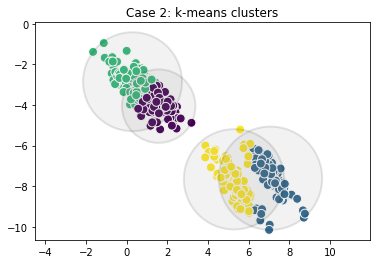

In [5]:
# Generate random data
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
kmeans = KMeans(4, random_state=0).fit(X_stretched)
plot_kmeans(kmeans, X_stretched, title='Case 2: k-means clusters')

Judging by the point clouds, it would seem that we have only three clusters and not four. But as you can see in the previous code cell, for this second case we only changed the initial $X$ feature matrix slightly. And as you see further above, $X$ was created with four cluster centers. More importantly though, we can see some weird behavior. Look at the upper-left point cloud. K-means is splitting that one into two leading to massive overlaps. This is certainly unexpected.

**Enter GMM.** Gaussian mixture models, or simply GMM, is a generative probabilistic model that tries to describe the underlying probability distribution that produced the data that we observe. So, strictly speaking, unlike k-means it is not a clustering model, but it can be used for that purpose. And like k-means GMM is an E-M algorithm too. It follows the following steps:

<p>&nbsp; &nbsp; 1. Guess some initial cluster centers</p>
<p>&nbsp; &nbsp; 2. Repeat until converged (i.e. until there is no more tangible improvement in the fitness function)</p>
<p>&nbsp; &nbsp; &nbsp; a) E-step: compute weights for the membership probability to each cluster for each data point</p>
<p>&nbsp; &nbsp; &nbsp; b) M-step: making use of the weights, update the location and shape of each cluster based on all points</p>

We'll circle back to the generative properties of GMM in an excursus below. But for now, let's see how GMM fares in these two fabricated cases. 

In [6]:
def draw_ellipse(position, covariance, **kwargs): 
    '''Draw an ellipse with given position & covariance.'''
    ax = plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, S, _ = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        w, h = 2 * np.sqrt(S)
    else:
        angle = 0
        w, h = 2 * np.sqrt(covariance)
    # Draw the ellipse
    for n in range(1, 4):
        ax.add_patch(Ellipse(position, n * w, n * h, angle, **kwargs))

In [7]:
def plot_gmm(gmm, X, title=None):
    '''Given a trained GMM algorithm, plot the clusters and
    respective ellipsoid shapes.'''
    # Fit model
    y_pred = gmm.fit_predict(X)
    # Plot clusters
    ax = plt.gca()
    ax.set_title(title)
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=y_pred, s=80, edgecolors='w')
    # Plot implied circular models
    w_factor = 0.2 / gmm.weights_.max()
    for p, c, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(p, c, alpha=w * w_factor, color='k', 
                     fc='gray', ls='-', lw=2, zorder=1)

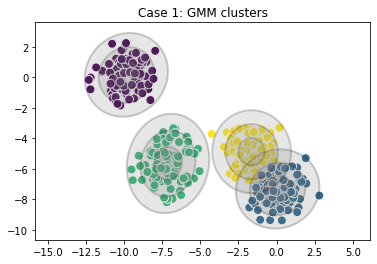

In [8]:
gmm = GaussianMixture(n_components=4, random_state=0).fit(X)
plot_gmm(gmm, X, title='Case 1: GMM clusters')

With GMM we can find the probabilites leading to the cluster assignment for each data point. Here for the first 5 points.

In [9]:
print(gmm.predict_proba(X)[-20:].round(3))

[[0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.497 0.    0.503]
 [0.    0.    1.    0.   ]
 [0.    0.031 0.    0.969]
 [0.    0.    0.    1.   ]
 [0.    0.443 0.    0.557]
 [0.    0.988 0.    0.012]
 [0.    1.    0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.996 0.    0.004]
 [0.    0.622 0.    0.378]
 [0.    0.    1.    0.   ]
 [0.    0.001 0.    0.999]
 [0.    0.992 0.    0.008]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    1.    0.   ]
 [1.    0.    0.    0.   ]]


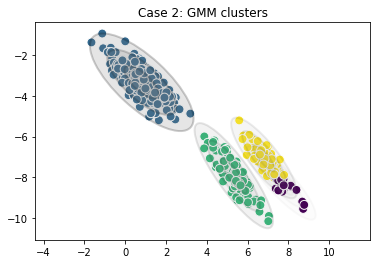

In [10]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=13).fit(X_stretched)
plot_gmm(gmm, X_stretched, title='Case 2: GMM clusters')

And the respective cluster assignment probabilities.

In [11]:
print(gmm.predict_proba(X_stretched)[-20:].round(3))

[[0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.    0.001 0.999 0.   ]
 [0.    1.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.028 0.    0.    0.972]
 [0.005 0.    0.    0.995]
 [0.    0.    1.    0.   ]
 [0.737 0.    0.    0.263]]


As this last plot clearly shows with GMM we can construct ellipsoid cluster shapes which far more flexible. We see too that GMM decides to leave the blue cluster at the top-left corner as one unit rather than splitting it like k-means did. This seems more intuitive.

**Conclusion.** GMM addresses the two main practical issues we have when using k-means, namely the lack of flexibility in cluster shape and lack of probabilistic cluster assignment. Next time you want to solve a clustering task, think of GMM!

# Excursus: generating new data with GMM

We said above we would circle back to the qualities GMM has being a generative probabilistic model. When you run a bunch of points through GMM what the algorithm does is estimate the (hypothetical) probability distribution where these points were randomly drawn from and stores these distributions. A cool thing we can do with those distributions is draw new samples from it!

But let's take something more exciting than randomly generated continuous features and feed the model with something visual. How about faces? Let's train the GMM algorithm with a faces dataset and draw some samples from the distributions estimated and see how these artificially generated faces look like.

Let's use again the "Labeled Faces in the Wild" (LFW) dataset that comes with `sklearn`. For more details on this dataset including a classification example, check out my other notebook 'face recognition'. You can also just google 'LFW' and should get more than enough info.

**Setup.**

In [12]:
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
lfw = fetch_lfw_people(min_faces_per_person=30)
lfw.data.shape

(2370, 2914)

**Load & plot data.**

In [13]:
# Helper function to plot the images
def plot_faces(data, h=5, w=6):
    fig, ax = plt.subplots(h, w, figsize=(h * 2, w * 2))
    for i, a in enumerate(ax.flat):
        a.imshow(data[i], cmap='gray')
        a.set(xticks=[], yticks=[])

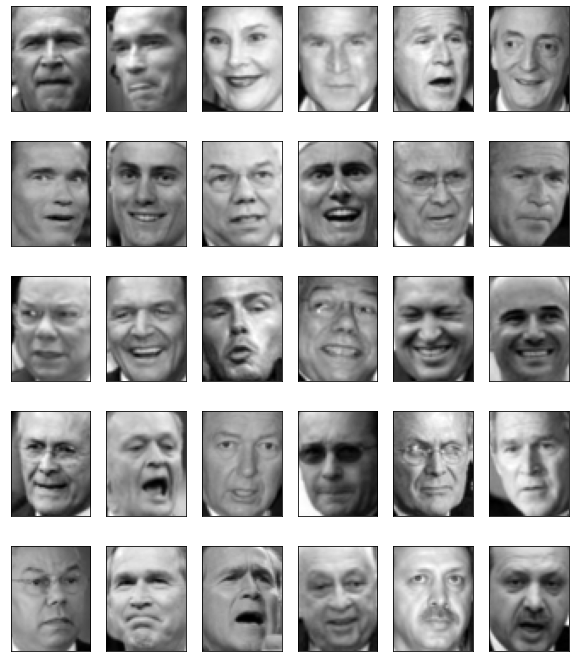

In [14]:
plot_faces(lfw.images)

Let's use PCA first to obtain a lower-dimensional representation of this data. We'll ask PCA to preserve 95% of the variance  in the projected data. As a result we use 171 projected axes instead of the 2,914 original ones.

In [15]:
# Compute PCA
pca = PCA(0.95, whiten=True)
lfw_projected = pca.fit_transform(lfw.data)
lfw_projected.shape

(2370, 171)

Now, let's assess with the Akaike Information Criterion (AIC) how many mixture components to use in our algorithm. By assigning the sumber of components we essentially define how many probability distributions, in the form of Gaussian densities, the model should estimate. We use AIC to evaluate the likelihood of the data given the model we pick. AIC simulates cross-validation and serves as a proxy for the models fit, i.e. is the model overfitting, underfitting or is it just right?

Below we simply loop over the different number of mixture components and store the AICs we get to see which number yields the lowest score.

In [16]:
# Compute AIC for different number of mixture components
n_components = np.arange(30, 80, 5)
gmms = [GaussianMixture(n, covariance_type='full', random_state=0)
        for n in n_components]
aics = [g.fit(lfw_projected).aic(lfw_projected) for g in gmms]

Text(0.5, 1.0, 'AIC for different GMM components in the LFW dataset')

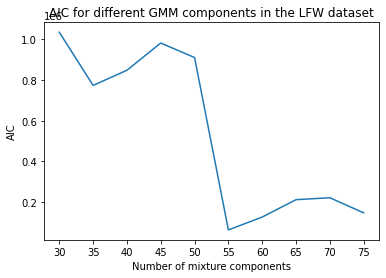

In [17]:
# Plot
plt.plot(n_components, aics)
plt.xticks(n_components)
plt.xlabel('Number of mixture components')
plt.ylabel('AIC')
plt.title('AIC for different GMM components in the LFW dataset')

In [18]:
print('AIC minimum is reached with {} GMM components.'.format(n_components[np.argmin(aics)]))

AIC minimum is reached with 55 GMM components.


It appears AIC is minimized with roughly 55 mixture components. Let's train now the GMM algorithm with 55 components on the projected LFW data. Also, let's briefly check that the model has in fact converged.

In [19]:
gmm = GaussianMixture(55, covariance_type='full', random_state=0).fit(lfw_projected)
print(gmm.converged_)

True


Now, the fun part: let's generate 50 random samples from the fitted Gaussian distribution and see what those faces look like.

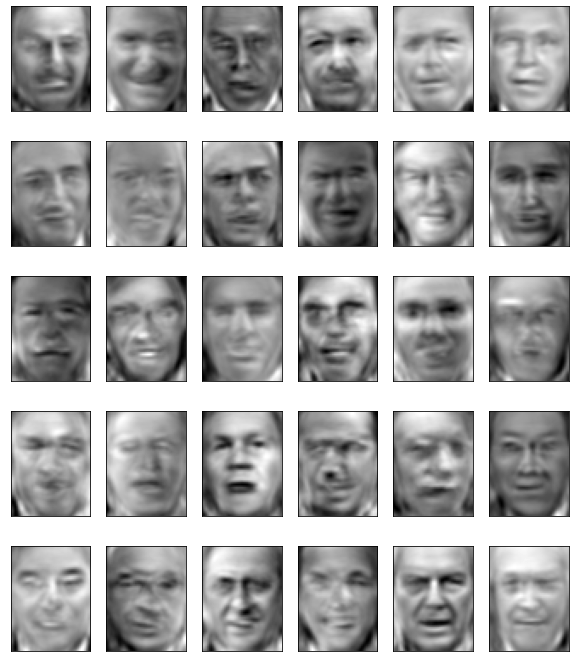

In [20]:
# Generate 50 random samples
X_new, _ = gmm.sample(50)
# Compute new feature matrix
lfw_new = pca.inverse_transform(X_new).reshape((50, 62, 47))
# Plot
plot_faces(lfw_new)

Presto! Either laugh at loud or be completely freaked out! :)

These are the faces the algorithm produced. Know anyone? :):)

**Conclusion.** So, to recap, what happened here? We 'fed' GMM with images of a bunch of people and it generated the probability distribution from which these faces came from. Of course, the underlying distribution pinned down by GMM is nowhere near resembling the true distribution of all faces out there! It can only work with what it has been given. So the faces the algorithm fabricates are in a way permutations and interpolations of the different elements of the faces the algorithm has seen in the dataset.